if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = test_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))# Pangyo AI Challenge 2021 - Mask Classification Baseline

## 라이브러리 호출 및 I/O

In [28]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import json
import pandas as pd

In [34]:
load_csv = pd.read_csv(os.path.join(RESULT_DIR, 'mask_pred_with_efficientnet_b1.csv'))

In [30]:
load_csv.answer = np.where(load_csv.answer.values == '[True]',1,0)

In [ ]:
load_csv.prob = load_csv.prob.apply(lambda  x: float(x[1:-1])).values

In [39]:
load_csv.prob = load_csv.prob.apply(lambda  x: 1 / (1+np.exp(-x))).values

In [47]:
load_csv.file_name = load_csv.index.values

In [48]:
load_csv

,file_name,answer,prob
0,0,0,0.226263
1,1,0,0.000001
2,2,1,0.999999
3,3,0,0.000010
4,4,0,0.009152
...,...,...,...
1021,1021,0,0.352064
1022,1022,1,0.996095
1023,1023,1,0.999990
1024,1024,1,1.000000


In [49]:
load_csv.to_csv(os.path.join(RESULT_DIR, 'mask_pred_with_efficientnet_b1.csv'), 
                    index=False
                   )

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# # 시드(seed) 설정

# RANDOM_SEED = 2021
# torch.manual_seed(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [5]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [6]:
# working directory 지정
ROOT_PATH = './'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, 'weights')
NUMPY_DIR = os.path.join(ROOT_PATH, 'numpy')
CSV_DIR = os.path.join(ROOT_PATH, 'csv')
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 2
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 5
INPUT_SHAPE = (184, 80)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
load_csv

## Dataloader

#### Train & Validation Set loader

In [51]:
class CustomDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']

    
def data_loader(data_dir=TRAIN_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db


if os.path.isfile(os.path.join(TRAIN_DIR, 'total.pkl')):
    db = pd.read_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
else:
    db = data_loader()
    db.to_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
    
    
# Do stratified split
from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(
    np.arange(len(db)),
    test_size=0.1,
    shuffle=True,
    stratify=db.label.values,
    random_state=seed)

train_db = db.iloc[train_idx]
valid_db = db.iloc[valid_idx]

train_db = train_db.reset_index()
valid_db = valid_db.reset_index()


transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [52]:
train_dataset = CustomDataset(db=train_db, mode='train', transform=transform)
validation_dataset = CustomDataset(db=valid_db, mode='val', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 24388 Val set samples: 2710


## Model

In [53]:
# !pip install git+https://github.com/rwightman/pytorch-image-models.git

In [54]:
import timm

In [55]:
# timm.list_models(pretrained=True)

In [56]:
BACKBONE = 'efficientnet_b1'

In [72]:
from torch.nn import functional as F
from efficientnet_pytorch import EfficientNet

class MaskClassifier(nn.Module):
    def __init__(self):
        super(MaskClassifier, self).__init__()
        self.model = timm.create_model(BACKBONE, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_img):
        x = self.model(input_img)
        x = self.softmax(x)
        return x

In [74]:
from torch.nn import functional as F
# for efficientnet
class MaskClassifier(nn.Module):
    def __init__(self):
        super(MaskClassifier, self).__init__()
        self.model = timm.create_model(BACKBONE, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 1)

    def forward(self, input_img):
        x = self.model(input_img)
        return x


## Just Trainer

In [75]:

# class Trainer():
#     """ Trainer
#         epoch에 대한 학습 및 검증 절차 정의
#     """
#     def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
#         """ 초기화
#         """
        
#         self.criterion = criterion
#         self.model = model
#         self.device = device
#         self.optimizer = optimizer
#         self.logger = logger
#         self.scheduler = scheduler
#         self.metric_fn = metric_fn

#     def train_epoch(self, dataloader, epoch_index):
#         """ 한 epoch에서 수행되는 학습 절차
#         """
#         self.model.train()
#         train_total_loss = 0
#         target_lst = []
#         pred_lst = []
#         prob_lst = []

#         for batch_index, (img, label) in enumerate(dataloader):
#             img = img.to(self.device)
#             label = label.to(self.device).long()
#             pred = self.model(img)
#             loss = self.criterion(pred, label)
#             self.optimizer.zero_grad()
#             loss.backward()
#             self.optimizer.step()
#             self.scheduler.step()
#             train_total_loss += loss.item()
#             prob_lst.extend(pred[:, 1].cpu().tolist())
#             target_lst.extend(label.cpu().tolist())
#             pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
#         self.train_mean_loss = train_total_loss / batch_index
#         self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
#         msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
#         print(msg)
        

#     def validate_epoch(self, dataloader, epoch_index):
#         """ 한 epoch에서 수행되는 검증 절차
#         """
#         self.model.eval()
#         val_total_loss = 0
#         target_lst = []
#         pred_lst = []
#         prob_lst = []

#         for batch_index, (img, label) in enumerate(dataloader):
#             img = img.to(self.device)
#             label = label.to(self.device).long()
#             pred = self.model(img)
#             ## coordinate loss
#             loss = self.criterion(pred, label)
#             val_total_loss += loss.item()
#             prob_lst.extend(pred[:, 1].cpu().tolist())
#             target_lst.extend(label.cpu().tolist())
#             pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
#         self.val_mean_loss = val_total_loss / batch_index
#         self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
#         msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
#         print(msg)
    


In [76]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device)
            pred = self.model(img).squeeze()

            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred.cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend((pred > 0.5).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device)
            pred = self.model(img).squeeze()
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred.cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend((pred > 0.5).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## MultiScale Trainer

In [77]:

class MultiScale_Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, scales, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.scales = scales
        self.scales_max_index = len(self.scales) - 1
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            
            img = TF.resize(img, self.scales[np.random.randint(0, self.scales_max_index)])
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## Metrics

In [78]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

In [79]:
class TaylorSoftmax(nn.Module):

    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out
    
class LabelSmoothingLoss(nn.Module):

    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        """Taylor Softmax and log are already applied on the logits"""
        #pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
class TaylorCrossEntropyLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.1):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(2, smoothing=smoothing)

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

## 학습을 위한 객체 선언

In [80]:
model = MaskClassifier().to(device)

# For Multi-GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
# model = nn.DataParallel(model)

In [81]:
# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim. lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=6, T_mult=1, eta_min=1e-6)
# criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()
metric_fn = get_metric_fn

# Set system logger
system_logger = get_logger(name='train',file_path='train_log.log')

# Set trainer
scales = [
    [140, 70], [180, 90], [220, 110], 
    [260, 130], [300, 150], [340, 170],
    [380, 190], [420, 210], [460, 230]
         ]
trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)

In [82]:
train_loss_history = []
train_acc_history = []

valid_loss_history = []
valid_acc_history = []

best_val_loss = None
best_val_acc = None

for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    train_loss_history.append(trainer.train_mean_loss)
    train_acc_history.append(trainer.train_score)
    
    valid_loss_history.append(trainer.val_mean_loss)
    valid_acc_history.append(trainer.validation_score)

    # don't use early stopper
    
    if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
        best_val_loss = trainer.val_mean_loss
        criterion = trainer.val_mean_loss
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

best_val_acc = max(valid_acc_history)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.3206732981999286, Acc: 0.8426685255043465, ROC: 0.9366867940375877


 50%|█████     | 1/2 [02:16<02:16, 136.47s/it]

Epoch 0, Val loss: 0.16737636388479274, Acc: 0.9350553505535055, ROC: 0.9835210367313137
Epoch 1, Train loss: 0.12846006535466742, Acc: 0.9495653600131212, ROC: 0.9894916458261965


100%|██████████| 2/2 [04:33<00:00, 136.60s/it]

Epoch 1, Val loss: 0.14048109787340762, Acc: 0.9472324723247233, ROC: 0.9871729354901809


In [90]:
best_val_acc = max(valid_acc_history)

In [91]:
best_val_acc

0.9472324723247233

In [83]:
def plt_loss(train_loss_history, valid_loss_history, backbone):
    plt.plot(train_loss_history, label="train loss")
    plt.plot(valid_loss_history, label="valid loss")
    plt.legend()
    plt.title(backbone)
    plt.show()

def plot_acc(train_acc_history, valid_acc_history, backbone):
    plt.plot(train_acc_history, label="train acc")
    plt.plot(valid_acc_history, label="valid acc")
    plt.legend()
    plt.title(backbone)
    plt.show()

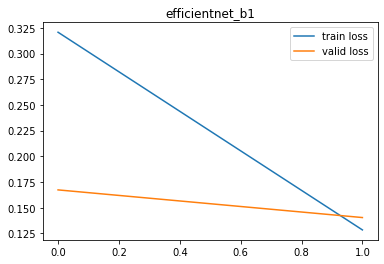

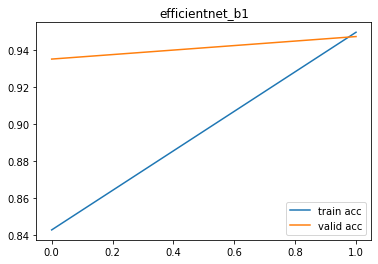

In [93]:
plt_loss(train_loss_history, valid_loss_history, BACKBONE)
plot_acc(train_acc_history, valid_acc_history, BACKBONE)

In [87]:
TIME = datetime.now().strftime('%m%d%H%M%S')

save_dict = {'backbone':BACKBONE,
             'time':TIME,
             'best_val_loss':best_val_loss,
             'best_val_acc':best_val_acc,
             'test_acc':None,
             'epochs':EPOCHS,
             'input_shape':INPUT_SHAPE,
             'augmentation':None,
             'optimizer':'Adam',
             'scheduler':'CosineAnnealingWarmRestarts',
             'attention_module':None,
             'learning_rate':LEARNING_RATE,
             'batch_size':BATCH_SIZE,
             'loss':'CrossEntropyLoss',
             'freeze':None,
             'others':'MultiScale Training',
             'randomeseed':seed,
             'train_loss':train_loss_history,
             'train_acc':train_acc_history,
             'valid_loss':valid_loss_history,
             'valid_acc':valid_acc_history}


with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
    json.dump(save_dict, f)

In [88]:
with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'r') as f:
    load_dict = json.load(f)

In [89]:
# load_dict

In [ ]:
# check how it looks
# load_dict

In [ ]:
save_csv = pd.DataFrame()

In [ ]:
save_csv = pd.read_csv(os.path.join(CSV_DIR, 'experiment.csv'))

In [ ]:
save_csv = save_csv.append(load_dict, ignore_index=True)

In [ ]:
save_csv.to_csv(os.path.join(CSV_DIR, 'experiment.csv'), 
                index=False
               )

In [ ]:
load_csv = pd.read_csv(os.path.join(CSV_DIR, 'experiment.csv'))

In [ ]:
load_csv

## Inference

In [ ]:
TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')

#### Test set Loader

In [ ]:
from modules.dataset import TestDataset
from modules.utils import load_yaml, save_csv

In [ ]:
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']


In [ ]:
def test_loader(data_dir=TEST_ANNOT_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db

In [ ]:
if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = test_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))

In [ ]:
transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
test_dataset = CustomDataset(db=test_db, mode='test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_num_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in enumerate(test_dataloader):
        img = img.to(device)
        pred = model(img)
        file_num_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

#### Save results as csv file

In [ ]:
df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
df.sort_values(by=['file_name'], inplace=True)
df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

In [ ]:
# df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
# df.sort_values(by=['file_name'], inplace=True)
# save_csv(path=(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), obj=df)

In [ ]:
trainer.validate_epoch(validation_dataloader, 0)